<a href="https://www.kaggle.com/code/annaattuch/dlip-notebook-group-4?scriptVersionId=285498832" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:#5F9EA0; 
            color:white; 
            padding:15px; 
            border-radius:10px; 
            text-align:center; 
            font-size:30px; 
            font-weight:bold;">
    Detecting Deep Fakes - A Deep Learning Computer Vision Task<br>
    <span style="font-size:20px; font-weight:normal;">
        Hairy Feet: Anna, Jacob, Johannes
    </span>
</div>

<h1 id = setup style = 'font-size:30px; background: linear-gradient(90deg, #5F9EA0, #7AC5CD, #8EE5EE); color: white; padding: 10px;  border-radius: 10px;'>
    1. Introduction: Project Overview & Data 
</h1

<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>
    
In this project, we build a deep learning computer vision model to distinguish between real human faces, and AI-generated (deepfake) face images. 

We use the **DeepDetect-2025** dataset from Kaggle, which contains over 100k labeled images of faces, split into two classes: real and fake. The goal is to train a binary classifier that can automatically detect whether an image is genuine or AI generated.

# 2. Methods

## 2.1 Importing and Preparing Data

In [2]:
import kagglehub

# Download CIFAKE dataset (for later use)
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

# Download Deepfake 20K
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

# Download Human-faces dataset
path = kagglehub.dataset_download("/kaggle/input/human-faces-dataset")

Path to dataset files: /kaggle/input/deepdetect-2025
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>

The DeepDetect-2025 dataset is organized into separate "train" and "test" folders, each containing two subfolders:

- "real" = real human face images  
- "fake" = AI-generated (deepfake) face images  

We will:
- Set a fixed image size and batch size
- Point TensorFlow to the "train" and "test" directories


In [1]:
import tensorflow as tf

deepdetect_train_dir = "/kaggle/input/deepdetect-2025/ddata/train"
deepdetect_test_dir  = "/kaggle/input/deepdetect-2025/ddata/test"

cifake_train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
cifake_test_dir  = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

df20k_dir = "/kaggle/input/deepfake-vs-real-20k/Deep-vs-Real"

hf_dir = "/kaggle/input/human-faces-dataset/Human Faces Dataset"

ds200k_dir = "/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/my_real_vs_ai_dataset/my_real_vs_ai_dataset"


2025-12-11 18:41:33.047760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765478493.283075      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765478493.349545      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'


<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>
    
Now we create the training, validation and test sets. 
We use tf.keras.utils.image_dataset_from_directory to:

- Load images from the "train"  directory
- Automatically split the training data into:
  - **80% training**
  - **20% validation**

The images in the "test" directory are used as a separate held-out test set that we will only use for final evaluation.

In [8]:
# Helper function for getting dataset
def create_ds(directory, subset, labels, IMG_SIZE=(224,224), BATCH_SIZE=None, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=0.2 if subset else None, # Only split if subset is asked for
        subset=subset,
        seed=2025,
        class_names=labels,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=shuffle # <--- Pass this through
    )
    return ds

# --- CIFAKE ---
ds_train_cifake = create_ds(cifake_train_dir, 'training', ['FAKE', 'REAL'])
ds_val_cifake   = create_ds(cifake_train_dir, 'validation', ['FAKE', 'REAL'])

ds_train_cifake = ds_train_cifake.apply(tf.data.experimental.ignore_errors()) # Because it has corrupted files that crash the system otherwise

#-- 200K Dataset--
ds_train_200k = create_ds(ds200k_dir, 'training', ['ai_images', 'real'])
ds_val_200k   = create_ds(ds200k_dir, 'validation', ['ai_images', 'real'])

# CIFAKE hold-out set
ds_test_cifake = create_ds(cifake_test_dir, None, ['FAKE', 'REAL'], shuffle = False)

# Out-of-Distribution (face) sets

# --- Deepfake 20k ---
ds_ood_df20k = create_ds(df20k_dir, None, ['Deepfake', 'Real'], shuffle = False)

# --- HF Dataset ---
ds_ood_hf = create_ds(hf_dir, None , ['AI-Generated Images', 'Real Images'], shuffle = False)

# 2. Concatenate them (Append HF to the end of DF20k)
ds_ood_combined = ds_ood_df20k.concatenate(ds_ood_hf)

print("Datasets created!")

KeyboardInterrupt: 

In [4]:
# Batch size
BATCH_SIZE = 64

# Define a helper to enforce shapes
def force_shape(image, label):
    # Explicitly set the shape. This converts RaggedTensors to Dense Tensors.
    image = tf.ensure_shape(image, (224, 224, 3))
    label = tf.ensure_shape(label, ())
    return image, label

# Full dataset function
def ds_full(datasets, weights, batch_size = 64):
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds_full = tf.data.Dataset.sample_from_datasets(
        datasets,
        weights=weights, # Optional: Balance the datasets if one is huge
        stop_on_empty_dataset=False
    )
    ds_full = ds_full.map(force_shape, num_parallel_calls=tf.data.AUTOTUNE)

    ds_full = ds_full.shuffle(buffer_size=1000)
    ds_full = ds_full.batch(batch_size)
    ds_full = ds_full.prefetch(tf.data.AUTOTUNE)

    return ds_full

# Test set function
def prepare_test_set(ds, batch_size=64):
    AUTOTUNE = tf.data.AUTOTUNE
    
    # 1. Force Shape (Same as before)
    ds = ds.map(force_shape, num_parallel_calls=AUTOTUNE)
    
    # 2. Batch (Critical)
    ds = ds.batch(batch_size)
    
    # 3. Prefetch (Speed)
    ds = ds.prefetch(AUTOTUNE)
    
    # NOTE: No shuffle(), No sample_from_datasets()
    return ds

# Full training set
ds_train_full = ds_full([ds_train_cifake, ds_train_200k], [1.0, 1.0])
print("Train Dataset Created!")

# Full validation set
ds_val_full = ds_full([ds_val_cifake, ds_val_200k], [1.0, 1.0])
print("Validation Dataset Created!")

# Test set
ds_test_cifake = prepare_test_set(ds_test_cifake)

ds_test_ood = prepare_test_set(ds_ood_combined)
Print("Test Datasets Created!")

Train Dataset Created!
Validation Dataset Created!


NameError: name 'ds_test_cifake' is not defined

## 2.2 Data Exploration and Visualisation

### 2.2.1 Show sample images from the training dataset
We visualize sample images by taking the first batch from the training dataset. Since the dataset is shuffled on loading, each batch is a random collection of images. From this batch, we display the first 9 images in a 3×3 grid along with their corresponding class labels (“real” or “fake”).

We do this to perform an initial quality check of the dataset: visual inspection allows us to confirm that the images were loaded correctly, that the labels correspond to the expected classes, and that there are no obvious issues such as corrupted files, incorrect preprocessing, or mislabeled images. Showing random samples also helps us get an intuitive understanding of what the model will see during training and whether the dataset contains sufficient visual variability for effective learning.

In [8]:
import matplotlib.pyplot as plt         
import numpy as np            
import os   

class_names = train_dd.class_names     
print("Class names:", class_names)      

plt.figure(figsize=(10, 10))            

for images, labels in train_dd.take(1):  

 for i in range(9):                   
        ax = plt.subplot(3, 3, i + 1)  
        plt.imshow(images[i].numpy().astype("uint8"))   
        plt.title(class_names[labels[i]])              
        plt.axis("off")                                 

plt.show()                             


NameError: name 'train_dd' is not defined

### 2.2.2 Check class distribution
We assess the class distribution by counting how many images belong to each category (“real” and “fake”). A balanced dataset is important because severe class imbalance can bias the model toward predicting the majority class. By examining the distribution visually and numerically, we ensure that the model will be trained on approximately equal amounts of real and AI-generated images, reducing the risk of skewed learning or misclassification patterns.

Number of training images:
Real: 48815
Fake: 41594


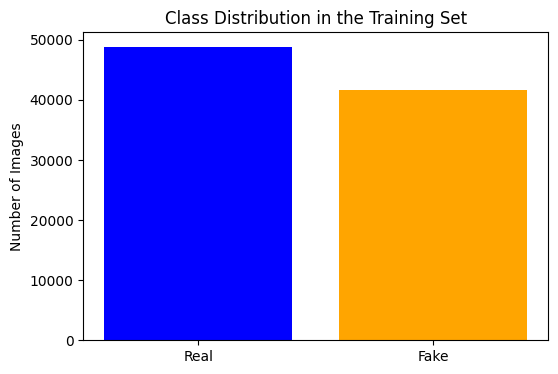

In [10]:
train_real = len(os.listdir(os.path.join(deepdetect_train_dir, "real")))
train_fake = len(os.listdir(os.path.join(deepdetect_train_dir, "fake")))

print("Number of training images:")
print("Real:", train_real)
print("Fake:", train_fake)

plt.figure(figsize=(6, 4))
plt.bar(["Real", "Fake"], [train_real, train_fake], color=["blue", "orange"])
plt.title("Class Distribution in the Training Set")
plt.ylabel("Number of Images")
plt.show()

### 2.2.3 Inspect Image Shape and Label Format
We inspect the shape of one batch to verify that the images and labels are formatted as expected. The image batch typically has the shape (batch_size, height, width, channels) e.g., (32, 224, 224, 3), indicating 32 RGB images of size 224×224 pixels.

The label batch should have the shape (batch_size,), containing one integer label per image. Confirming these shapes helps ensure that the data pipeline is correctly configured before building the neural network model.

In [ ]:
for batch_images, batch_labels in train_dd.take(1):
    print("Image batch shape:", batch_images.shape)
    print("Label batch shape:", batch_labels.shape)
    print("Example label:", batch_labels[0].numpy())
    break

The batch shape (32, 224, 224, 3) confirms that images are correctly loaded in batches of 32, each resized to 224×224 pixels with three RGB channels. The label batch (32,) shows that each image has one corresponding class label. The example label 0/1 indicates that the labeling system is functioning as expected and correctly maps images to their respective classes. Overall, the data pipeline is properly structured for model training.

## 2.3 Data Preprocessing

### 2.3.1 Data Augmentation
We apply data augmentation to artificially increase the variability of the training dataset and improve the model’s ability to generalize. The augmentation pipeline randomly flips, rotates, and zooms images during training, introducing meaningful variations that help the model become more robust to common transformations. This reduces overfitting and improves performance on unseen data.


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   
    tf.keras.layers.RandomRotation(0.1),        
    tf.keras.layers.RandomZoom(0.1),            
], name="data_augmentation")

### 2.3.2 Visualizing Data Augmentation
We visualize a batch of augmented images to verify that the applied transformations (flipping, rotation, and zoom) behave as intended and produce realistic variations. This quick inspection ensures that augmentation does not distort the data in a harmful way and confirms that the model will receive meaningful, correctly transformed inputs during training.

In [11]:
for images, labels in train_dd.take(1):
    augmented = data_augmentation(images)
    break

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

NameError: name 'train_dd' is not defined

## 2.4 Neural Models

### 2.4.1 Custom CNN

**Architecture**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

# Custom-made CNN classifier 
custom_cnn = keras.Sequential([
    # Input layer
    layers.Input(shape=(224, 224, 3)),
    
    # First convolution + maxpool block (32 filters)
    layers.Conv2D(filters=32, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Second convolution + maxpool block (64 filters)
    layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Third convolution + maxpool block (128 filters)
    layers.Conv2D(filters=128, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    #Fourth convolution + maxpool block (256 filters)
    layers.Conv2D(filters=256, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),
    # removed maxpool to preserve fine-grained details

    # Global average pooling block
    layers.GlobalAveragePooling2D(),

    # Fully connected block
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
    
])

custom_cnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

custom_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 433,601 (1.65 MB)

 Trainable params: 432,641 (1.65 MB)

 Non-trainable params: 960 (3.75 KB)

### 2.4.2 Pre-trained CNN

**Architecture**



In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 224
BATCH_SIZE = 32

# Load pretrained EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # freeze weights for transfer learning

# Build model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_cnn = models.Model(inputs, outputs)

model_cnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_cnn.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 2.4.3 Visual Transformer

**Architecture**

In [10]:
# ------------------------------
# 1️⃣ Imports & Setup
# ------------------------------
import torch
from torch import nn
from torch.optim import AdamW
from transformers import ViTForImageClassification
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import os

# Enable faster TF GPU memory allocation
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ------------------------------
# 2️⃣ Load Model & Optimize
# ------------------------------
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# --- SPEEDUP 1: Compile the model (PyTorch 2.0+) ---
# This fuses layers and optimizes the computation graph.
# If this errors (rare on old setups), comment it out.
try:
    print("Compiling model with torch.compile...")
    model = torch.compile(model)
except Exception as e:
    print(f"Skipping torch.compile (not supported): {e}")

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# --- SPEEDUP 2: Mixed Precision Scaler ---
# This manages the math for 16-bit training automatically.
scaler = torch.amp.GradScaler('cuda')

# ------------------------------
# 3️⃣ Optimized Data Transfer
# ------------------------------
def tf_to_torch_fast(images, labels):
    # 1. Zero-copy from TF to Torch on CPU
    images = torch.from_numpy(np.array(images)) 
    labels = torch.from_numpy(np.array(labels)).long().to(device)

    # 2. Move raw uint8 to GPU (Small transfer)
    images = images.to(device, non_blocking=True)

    # 3. Process on GPU
    images = images.permute(0, 3, 1, 2) # (B, H, W, C) -> (B, C, H, W)
    images = images.float() / 255.0     # Normalize
    
    return images, labels

# ------------------------------
# 4️⃣ Training Loop with AMP
# ------------------------------
# Consider increasing Batch Size in your TF dataset creation if VRAM allows!
train_dataset = tfds.as_numpy(ds_train_full) 

EPOCHS = 1

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"🚀 Starting Epoch {epoch+1} with Mixed Precision...")
    
    for batch_idx, (images, labels) in enumerate(train_dataset):
        images, labels = tf_to_torch_fast(images, labels)
        
        optimizer.zero_grad()
        
        # --- SPEEDUP 3: Automatic Mixed Precision Context ---
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
        
        # Scale the loss and step (handles FP16 gradients)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics
        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 100 == 0 and batch_idx > 0:
            print(f"  Batch {batch_idx}: Acc: {correct/total:.4f}")

    if total > 0:
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch+1} Finished — Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compiling model with torch.compile...
🚀 Starting Epoch 1 with Mixed Precision...


W1211 17:31:30.814000 234 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


  Batch 100: Acc: 0.4907
  Batch 200: Acc: 0.5039


Invalid SOS parameters for sequential JPEG


  Batch 300: Acc: 0.5076
  Batch 400: Acc: 0.5087
  Batch 500: Acc: 0.5208
  Batch 600: Acc: 0.5366
  Batch 700: Acc: 0.5501
  Batch 800: Acc: 0.5554
  Batch 900: Acc: 0.5651
  Batch 1000: Acc: 0.5750
  Batch 1100: Acc: 0.5844
  Batch 1200: Acc: 0.5934
  Batch 1300: Acc: 0.6016
  Batch 1400: Acc: 0.6109
  Batch 1500: Acc: 0.6211
  Batch 1600: Acc: 0.6305
  Batch 1700: Acc: 0.6395
  Batch 1800: Acc: 0.6489


UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:4 transformation with iterator: Iterator::Root::ParallelMapV2::Prefetch::BatchV2::Shuffle::ParallelMapV2::DirectedInterleave[0]::Prefetch::ParallelMapV2: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE/3509.jpg; Unknown error 512
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 

## 2.5 Loss and Performance Metrics

## 2.6 Fitting


### 2.6.1 Early Stopping

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',        # Watch validation loss (metric of truth)
    patience=3,                # Wait 3 epochs before stopping (gives it a chance to recover)
    restore_best_weights=True, # CRITICAL: Go back to the best weights, not the last ones
    verbose=1                  # Print a message when it triggers
)

### Function for training, predicting and cleaning (llm)

In [ ]:
import gc
import numpy as np
import tensorflow as tf

# Initialize the global results dictionary if it doesn't exist
if 'all_results' not in globals():
    all_results = {}

# Define your test sets map
test_sets = {
    "CIFAKE_Test": ds_test_cifake,
    "OOD_Test":   ds_test_ood
}

def train_eval_clean(model, model_name, train_ds, val_ds, test_sets, epochs=30):
    """
    1. Trains the model.
    2. Evaluates on all test/OOD sets.
    3. Saves results to global 'all_results'.
    4. Saves model to disk.
    5. Deletes model and clears VRAM.
    """
    print(f"\n{'='*60}")
    print(f"🚀 STARTING PIPELINE FOR: {model_name}")
    print(f"{'='*60}")

    # ---------------------------------------------------------
    # 1. TRAIN
    # ---------------------------------------------------------
    print(f"📉 Training {model_name}...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping] # Assumes 'early_stopping' is defined globally
    )

    # ---------------------------------------------------------
    # 2. EVALUATE
    # ---------------------------------------------------------
    print(f"\n🔍 Evaluating {model_name} on {len(test_sets)} datasets...")
    
    # Create entry in global results dict
    all_results[model_name] = {}

    for ds_name, ds in test_sets.items():
        print(f"   • Predicting on {ds_name}...")
        
        # A. Predict
        preds = model.predict(ds, verbose=0) # verbose=0 to keep logs clean
        
        # Handle shapes: (N, 2) -> (N,) or (N, 1) -> (N,)
        if preds.shape[-1] > 1:
            y_pred = preds[:, 1] 
        else:
            y_pred = preds.flatten()
            
        # B. Get True Labels
        y_true = np.concatenate([y for x, y in ds], axis=0)
        
        # C. Store
        all_results[model_name][ds_name] = {
            'y_pred': y_pred,
            'y_true': y_true
        }

    # ---------------------------------------------------------
    # 3. SAVE TO DISK
    # ---------------------------------------------------------
    filename = f"{model_name}_final.keras"
    model.save(filename)
    print(f"\n💾 Model saved to: {filename}")

    # ---------------------------------------------------------
    # 4. CLEANUP (The most important part)
    # ---------------------------------------------------------
    print(f"🧹 Scrubbing VRAM...")
    del model
    tf.keras.backend.clear_session()
    gc.collect()
    print(f"✨ {model_name} pipeline complete. GPU is ready for next model.\n")
    
    return history

### 2.6.2 Custom CNN

In [13]:
hist_custom = train_eval_clean(
    custom_cnn, 
    "Custom_CNN", 
    ds_train_full, 
    ds_val_full, 
    test_sets,
    epochs=2 # Change to 30 for real run
)

Epoch 1/2
     47/Unknown 6s 117ms/step - accuracy: 0.7805 - loss: 0.4269

KeyboardInterrupt: 

### 2.6.3 Pre-trained CNN

In [14]:
hist_cnn = train_eval_clean(
    model_cnn, 
    "Pretrained_CNN", 
    ds_train_full, 
    ds_val_full, 
    test_sets,
    epochs=2 # Change to 30 for real run
)


    150/Unknown 11s 70ms/step - accuracy: 0.7414 - loss: 0.5128

KeyboardInterrupt: 

### 2.6.3 Visual Transformer

# 3. Results

## 3.1 Hold-out set performance 

## 3.2 Out-of-distribution set performance

## 3.3 Performance on custom images 

In [ ]:
# use a pic of johannes and a pic of ai generated johannes to see if it predicts correctly 

# 4. Conclusion/Discussion

# 5. References

# 6. Division of Labour